## Fine-tune llama-2 7b on Google Colab free tier

In this notebook we'll fine tune the llama2 7b, Meta's latest release of the open source Llama model using Google Colab's free tier. The free-tier of Google Colab has a few limitations which we need to work around:
1. We have 12.7 GB of system RAM
2. We have 15.0 GB of GPU RAM (VRAM)
3. We're limited to 78.2 GB of disk storage

Each one of these limitations leads to some difficulty in fine-tuning and using the fine-tuned model, so we'll find ways to work around the difficulties.

For fine tuning we'll use either (or both!) of openassistant-guanaco or databricks-dolly datasets. These datasets are in the form of instruction/response pairs so they are good datasets to use for fine-tuning the base llama2 language model to follow instructions.

### Preliminaries

First we install a few libraries and import the dependencies we need. We'll go over these as they're used

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 tensorboard huggingface_hub[cli]

We also have to log in to hugging face to access the Llama model distributed by Meta. To do so you have to submit a license request on the Meta website and then submit a request via Huggingface as well to link your approved license from Meta to your hugging face account.

Make sure you use the email address linked to your huggingface account to submit the model license request to Meta.

In case you don't want to go through the steps for getting the license and linking to your huggingface account, you can use an alternate distribution of the model from guardrail (just change the `model_name` parameter in the snippets below

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Loading the model

In order to get started with fine-tuning, we need to load the model to train it. This poses a few challenges based on system constraints. First, the base llama2-7b model released by meta does not fit into the 12GB system ram we have available which causes the Colab runtime to crash when we try loading the model.

Let's try to load this model to see what happens.

In [ ]:
import os
import torch

from datasets import load_dataset
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging
)
from peft import LoraConfig
from trl import SFTTrainer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# The models which can be loaded from the HuggingFace hub
model_name_meta = "meta-llama/Llama-2-7b-chat-hf"
model_name_guardrail = "guardrail/llama-2-7b-guanaco-instruct-sharded"

#### Insufficient RAM

In [ ]:
# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    model_name_meta,
)
# You should see the runtime crash and restart when running this cell.
# Once the runtime restarts, skip running this cell.

As we anticipated, the runtime gets restarted because we run out of system RAM. We could also try to load the model directly into GPU memory where we have a few additional GB available. Let's try that

In [ ]:
# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    model_name_meta,
    device_map={"": 0}      # This instructs the loader to place all the model layers on gpu device 0
)
# You should see an OutOfMemoryError below when running this cell.
# Once you get the error, manually restart the runtime
# Skip running the cell before this and this cell as well.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: ignored

Even the direct to GPU approach doesn't work. The model seems to need more than the 14.7 GiB (15 GB) which is available for us to use on the GPU. So what do we do?

#### Quantization
We're going to use quantisation to load the model into memory. Quantisation is a technique which uses fewer number of bits to represent a model parameter.

If we represent a model's weights as a regular floating point number, then we'd use 64 bits or 8 bytes to represent a parameter. We call this fp64 precision.
A model with 7b parameters would need `7B*8 bytes = 56 GB` to reside in memory.

Quantisation allows us to represent the model parameters in lower precision to reduce the memory required. Most transformer models are trained in mixed precision with a mix of fp16+fp32 parameters i.e. some parameters are represented in 16 bits (2 bytes) and some in 32 bits (4 bytes).
The lowered precision sacrifices model performance but saves memory.

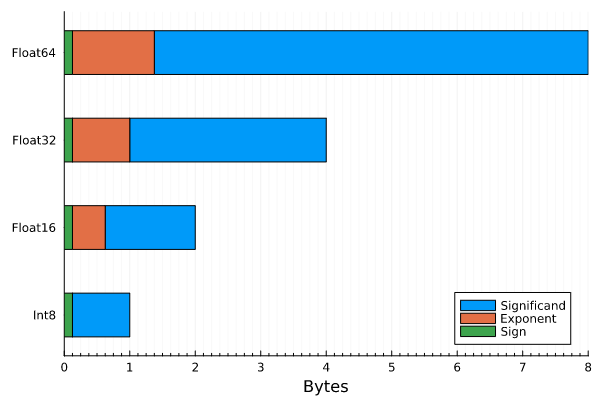

_Fig 1: Parameter precision (from EleutherAI's [Transformer Math](https://blog.eleuther.ai/transformer-math/))_

However, with 15GB available to us, we can't even use such a mixed precision model. We in-fact can at most afford to use 15GB/7B ~ 2 bytes (16 bits) per parameter.

So how do we take a model which was trained in fp16+fp32 and load it using only 2 bytes per parameter? A library from HuggingFace called bitsandbytes comes handy. It allows us to dynamically change the precision used when loading a model into memory independently of the precision used when training the model.

#### Quantization config
In the configuration below we actually set the model to be loaded in 4 bits per parameter. This is because the 2 bytes or 16 bits we computed above is sufficient to keep just the model parameters in memory. Having just the parameters is fine if we want to run inference on the model.

However, if we want to train the model we'll also need to compute the loss and calculate gradients in the backward pass in order to update the model parameters. Additionally, if we're using an optimizer such as Adam, there will also be optimizer state which needs to be stored. All these parameters add up on the GPU driving the memory needed to 3-4x the memory needed for inference. So we load the model in even lower precision to keep room available for training.

In [ ]:
# Set the name of the model we'll use for the rest of the notebook
model_name = model_name_meta

# Load the entire model on the GPU 0
device_map = {"": 0}

################################################
# Parameters for quantisation in bits and bytes
################################################

# Set base model loading in 4-bits
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [ ]:
# Load the model using quantised settings
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant
)
# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device_map,
    quantization_config=bnb_config,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

#### Tokenizer

We provide a prompt to the model to generate output. However, LLMs don't directly work on text as input -- we convert the text into integers for the model to be able to understand the input.

The conversion happens through a process of tokenization. To correctly use or fine-tune the model, we must use the same tokenization used during original training to convert our prompt text to integers. We load the tokenizer which is exported to the Huggingface hub along with the model parameters keeping the model and tokenizer in sync.

##### Padding

After loading the tokenizer, we make a small change to it -- setting the padding token. The padding token is used when a text sequence is shorter than the model's context length (4k).

One option (which is repeated in quite a few places online) is to use the model's end-of-sequence (eos) token as the padding token. However, if you think about it, during training LLM should learn to never generate a padding token. Since it's simply a way to fill the input, it should never appear in the generated output. If we use the eos token as padding, during training we'll end up instructing the model to never generate an end-of-sequence. Given a prompt, the model will simply keep generating text without end and we'll need to forcibly cut it off at some point.

Instead, we create our own padding token `<PAD>` and use that in place of the eos token.

We can add this to the tokenizer using the `add_special_tokens` API, or we can set the `pad_token` attribute. For some reaason using the `add_special_tokens` API causes a GPU level error (also seen as a `CUDA: device side assert` error). I believe this has to do with a change in the embedding dimensions but haven't quite been able to verify this as yet. So we use the `.pad_token = ` option to set the padding token.

We also set the padding direction to be right. This means the tokenizer will add padding to the right of a sequence i.e. after the text.

In [ ]:
# Load the model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

## The default tokenizer does not specify a pad token so we have to define one.
##
## One option is for us to use the
## Apparently the following will cause the model to never generate an EOS token
# tokenizer.pad_token = tokenizer.eos_token
## This second setting triggers a CUDA device side assertion failure
# tokenizer.add_special_tokens({'pad_token': '<PAD>'})
## This is the magic incantation which makes things work
tokenizer.pad_token = "<PAD>"
# Apparently this is a fix for fp16 training -- left side padding causes crashes
tokenizer.padding_side = "right"

### Inference

With the model and it's tokenizer loaded into memory, let's try running inference on the model to see how it does in a chat setting.

> _**Note**: Running inference consumes GPU memory which might cause you to run out of memory during training. To be on the safe-side, restart the runtime and load the model afresh before starting training_

In [ ]:
# Create a text generation pipeline which use the model and the tokenizer loaded
generator = pipeline(task="text-generation", model=model, tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
# Now define a prompt and send it to the model to generate a response.
# Ignore the special tokens <s>, [INST] and [/INST] for now, we get to them shortly
prompt = "<s>[INST] I want to take a skiing vacation.  Which of the following countries would be suitable for doing this: Switzerland, Cyprus, Kiribati, the United States, Haiti. [/INST] "
print(prompt)
generator(prompt, max_new_tokens=100)

<s>[INST] I want to take a skiing vacation.  Which of the following countries would be suitable for doing this: Switzerland, Cyprus, Kiribati, the United States, Haiti. [/INST]




[{'generated_text': '<s>[INST] I want to take a skiing vacation.  Which of the following countries would be suitable for doing this: Switzerland, Cyprus, Kiribati, the United States, Haiti. [/INST]\n\nSwitzerland is the most suitable country for a skiing vacation among the options provided. Switzerland is known for its world-class ski resorts, such as Zermatt, St. Moritz, and Interlaken, which offer a wide range of skiing options for all skill levels. The country has a long skiing tradition and boasts some of the most modern and well-maintained ski resorts in Europe.\nCyprus, Kiribati, and Hait'}]

As you can see the model is decent at generating usable text in an instruction setting. As we fine-tune it on our instruction dataset we should be able to improve its performance even further.

### Training
With the model loaded into memory and running inference, we can now focus on training.

#### Dataset formatting

In order to fine-tune the model, we'll need to provide training data to the model. We'll format the data according to the prompt it expects and use the tokenizer to convert the text input and outputs into integers. The cell below defines a few formatting functions which can be used to format the prompt when fine-tuning a model.

Specifically, to generate a response the Llama-chat model expects a prompt of the form:
```
<s>[INST] {user_message} [/INST]
```

Hence we construct training data of the form:
```
<s>[INST] {user_message} [/INST] {response}
```
to train the model to generate a given response when looking at a specific prompt.

We take a sample of the source dataset and then format the contents according to the prompt template. The functions below have support for either the Guanaco prompt format or the Lllama prompt format.

In [ ]:
def format_dolly_for_llama(sample):
    instruction = f"<s>[INST] {sample['instruction']}"
    context = f" Here's some context: {sample['context']}" if sample['context'] else None
    response = f" [/INST] {sample['response']}"
    prompt = "".join([i for i in [instruction, context, response] if i is not None])
    return prompt

def format_dolly_for_guanaco(sample):
    instruction = f"### Human: {sample['instruction']}"
    context = f" Here's some context: {sample['context']}" if sample["context"] else None
    response = f"### Assistant: {sample['response']}"
    # join all the parts together
    prompt = "".join([i for i in [instruction, context, response] if i is not None])
    return prompt

# Used only for mlabonne/guanaco-llama2*
def format_mlabonne_llama2_for_guanaco(sample):
  parts = sample['text'].split(" [/INST]")
  instruction, response = parts[0], parts[1]
  # Strip out any extra whitespace from the instruction
  instruction = f"### Human: {instruction.split('[INST]')[1]}"
  response = f"### Assistant {response}"
  return "\n\n".join([instruction, response])


# Used to format a dataset in guanaco format for use with the llama instruction
# prompt
def format_guanaco_for_llama(sample):
    dialog = sample['text'].split('### Human: ')
    prompts = []
    for exchange in dialog:
        if not exchange.strip(): continue
        parts = exchange.split('### Assistant: ')
        if len(parts) > 1:
            prompt = f"<s>[INST] {parts[0]} [/INST] {parts[1]}</s>"
        else:
            prompt = f"<s>[INST] {parts[0]} [/INST]"
        prompts.append(prompt)
    return "".join(prompts)


# template dataset to add prompt to each sample
def template_dataset(sample):
    sample["text"] = f"{dataset_formatter(sample)}{tokenizer.eos_token}"
    return sample


# The instruction dataset to use
dataset_name_dolly = "databricks/databricks-dolly-15k"
# mlabonne guanaco dataset is formatted according to the llama prompt
dataset_name_guanaco_mini = "mlabonne/guanaco-llama2-1k"
dataset_name_guanaco_full = "timdettmers/openassistant-guanaco"
dataset_name = dataset_name_guanaco_full
# format_dolly* or format_mlabonne_llama2 or None (for openassistant-guanaco)
dataset_formatter = format_guanaco_for_llama
dataset_sample = 2000

dataset = load_dataset(dataset_name, split="train")
if dataset_sample > 0:
  dataset_shuffled = dataset.shuffle(seed=1234)
  dataset = dataset_shuffled.select(range(dataset_sample))

if dataset_name == dataset_name_dolly or dataset_name == dataset_name_guanaco_mini or (dataset_name == dataset_name_guanaco_full and model_name == model_name_meta):
    # apply prompt template per sample in case of dolly and guanaco datasets
    dataset = dataset.map(template_dataset, remove_columns=[f for f in dataset.features if not f == 'text'])

# Fine-tuned model name
if dataset_name.endswith('dolly-15k'):
    new_model = f"{model_name.split('/')[1]}-{dataset_name.split('/')[1][:-4]}-{dataset.num_rows/1000}k"
elif dataset_name.endswith('guanaco'):
    new_model = f"{model_name.split('/')[1]}-{dataset_name.split('/')[1]}-{dataset.num_rows/1000}k"
else:
    new_model = f"{model_name.split('/')[1]}-{dataset_name.split('/')[1]}"
dataset_name, dataset, new_model

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

('timdettmers/openassistant-guanaco',
 Dataset({
     features: ['text'],
     num_rows: 2000
 }),
 'llama-2-7b-guanaco-instruct-sharded-openassistant-guanaco-2000')

In [ ]:
# Printing a sample in the dataset
print(dataset[735]['text'])

### Human: I will give you a list of food items. You will have to combine some of them in order to make a weekly dietary schedule for lunches considering healthiness and complete nutrition. List: [lettuce, cherry tomatoes, pork chops, beef, onion, celery, pasta, flaxseeds, carob rusk, butter, mushrooms, lentils, asparagus, garlic, flour, rocket, chickpeas, beans, fish, chicken breast]### Assistant: Sure, here is a sample weekly dietary schedule for lunches incorporating a variety of the food items you listed:

Monday:

    Grilled chicken breast with roasted asparagus and mushrooms on the side.
    A mixed greens salad with cherry tomatoes, lettuce, and rocket.
    A piece of carob rusk for dessert.

Tuesday:

    Lentil soup with garlic and celery.
    A mixed greens salad with cherry tomatoes, lettuce, and rocket.
    A piece of carob rusk for dessert.

Wednesday:

    Grilled fish with a side of baked potatoes and butter.
    A mixed greens salad with cherry tomatoes, lettuce, and r

In [ ]:
# Optional, can run inference on a single item in the dataset
prompt = f"{dataset[393]['text'].split('[/INST]')[0]}[/INST] "
print(prompt)
generator(prompt, max_new_tokens=250)

With the training data out of the out of the way, we turn our attention to the training parameters.

#### Parameter efficient fine-tuning: **LoRA** and QLoRA

LoRA is an efficiency technique for lowering the memory requirements when fine-tuning an LLM. It falls into the larger category of parameter efficient fine-tuning or PeFT techniques. LoRA approximates a large weight matrix using two smaller matrices which when multiplied together will result in the larger matrix.

Eg: If we have a 1000x1000 weight matrix (W), W contains about 1MM values. If trained in fp32 precision, W will require 4 bytes per value and will need about 4MB of memory.

The key intuition here is that we can approximate W as the product of two matrices with fewer rows/columns. Eg: W_a of size 1000x64 and W_b of size 64x1000 when multiplied together will result in a matrix of size 1000x1000. W_a and W_b have about 128K values together or 512MB memory -- approximately 8x less than the original W matrix.

##### QLoRA
QLoRA is a further optimisation of the LoRA approach. We can learn the weigths of W_a and W_b using only 16 bits (2 bytes) per parameter. This further reduces the memory foorprint for the parameters trained in 32-bit precision by a factor of 2.

The configuration to use 16 bits during training is actually not defined in the parameters below but in the `BitsAndBytes` configuration we added when loading the model. The `bnb_4bit_compute_dtype` parameter sets the type to use when computing parameters which have been loaded in 4 bits.

While fine-tuning the model we run the training steps to learn the updates which have to be applied to W through the low-rank matrics W_a and W_b. After training is done we take the final low-rank matrices W_a and W_b, multiply them together and add to W to produce the new weight matrix.

In [ ]:
########################################
# QLoRA parameters
########################################

# LoRA attention dimension
lora_r = 64
# Alpha for LoRA scaling
lora_alpha = 64
# Dropout probability for LoRA
lora_dropout = 0.1

# Create the LoRA configuration
peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    inference_mode=False,
    bias="none",
    task_type="CAUSAL_LM",
)

#### Training parameters & loop

The rest of the training arguments are below. These are mostly self-explanatory and some comments inline help to explain specific settings.

In [ ]:
########################################
# Parameters for TrainingArguments
########################################

# Where to save model predictions and checkpoints
output_dir = "./results"
final_checkpoint_dir = os.path.join(output_dir, "final_checkpoint")


# Training epochs
num_train_epochs = 1
# Num training steps (which overrides num_train_epochs)
max_steps = -1

# Enable fp16/bf16 training (bf16 can be true on an A100)
bf16 = False
fp16 = True

# Training batch size per GPU
per_device_train_batch_size = 4
# Evaluation batch size per GPU
per_device_eval_batch_size = 4
# Number of batches to accumulate gradients
gradient_accumulation_steps = 1

# Maximum gradient for clipping
max_grad_norm = 0.3
# Optimizer
optim = "paged_adamw_32bit"
# Initial learning rate (AdamW optimizer)
learning_rate = 4e-5
# LR scheduler type, alternatives "constant"|"cosine"
lr_scheduler_type = "constant"
# Ratio of steps for linear warmup (from 0 to learning rate)
warmup_ratio = 0.03
# Weight decay for all layers excluding bias/LayerNorm weights
weight_decay = 0.001

# Group sequences into batches with the same length
# (this saves memory and speeds up training)
group_by_length = True

# Gradient checkpoints
gradient_checkpointing = True
# Save checkpoint frequency
save_steps = 50
# Log frequency
logging_steps = 10

# Set the training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
)

In [ ]:
import transformers

########################################
# Supervised Fine Tuning parameters
########################################
# Maximum sequence length
max_seq_length = None
# Pack multiple short examples in the same input to make fine-tuning more efficient
packing = False


# Set the supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

print(f"New model name: {new_model}")

# In case the training is stopped, this can be set to the path to a saved checkpoint to resume training.
resume_checkpoint = None
# Run the training
transformers.logging.set_verbosity_info()
trainer.train(resume_checkpoint)
# Save the trained model
trainer.save_model(final_checkpoint_dir)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

New model name: llama-2-7b-guanaco-instruct-sharded-openassistant-guanaco-2000


***** Running training *****
  Num examples = 2,000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 33,554,432
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
20,1.433500
40,1.705300
60,1.665400
80,1.340900
100,1.875500
120,1.297200
140,1.465700
160,1.566200
180,1.214600
200,1.663900


Saving model checkpoint to ./results/checkpoint-50
tokenizer config file saved in ./results/checkpoint-50/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-50/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-100
tokenizer config file saved in ./results/checkpoint-100/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-100/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-150
tokenizer config file saved in ./results/checkpoint-150/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-150/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-200
tokenizer config file saved in ./results/checkpoint-200/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-200/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-250
tokenizer config file saved in ./results/checkpoint-250/tokenizer_config.json
Special tokens file saved in ./results/ch

In [ ]:
!mkdir -p drive/MyDrive/Colab\ Notebooks/Llama2_finetune/results-guanaco-2k-aug18
# Copy final_checkpoint to Google Drive so we can terminate the Colab instance without losing trained parameters
!cp -r ./results/final_checkpoint drive/MyDrive/Colab\ Notebooks/Llama2_finetune/results-guanaco-2k-aug18/final_checkpoint

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir results/runs

In [ ]:
# Find out which cached models are contributing to the most disk usage
!du -h --max-depth=3 /root/

4.0K	/root/.nv/ComputeCache
8.0K	/root/.nv
4.0K	/root/.config/matplotlib
8.0K	/root/.config/configstore
145M	/root/.config/Google/DriveFS
145M	/root/.config/Google
145M	/root/.config
28K	/root/.local/share/jupyter
36K	/root/.local/share
44K	/root/.local
68K	/root/.jupyter
14M	/root/.cache/pip/wheels
122M	/root/.cache/pip/http
135M	/root/.cache/pip
60K	/root/.cache/torch/kernels
64K	/root/.cache/torch
26G	/root/.cache/huggingface/hub
89M	/root/.cache/huggingface/datasets
26G	/root/.cache/huggingface
7.1M	/root/.cache/node-gyp/14.16.0
7.1M	/root/.cache/node-gyp
36K	/root/.cache/matplotlib
26G	/root/.cache
12M	/root/.npm/_cacache/content-v2
4.0K	/root/.npm/_cacache/tmp
872K	/root/.npm/_cacache/index-v5
12M	/root/.npm/_cacache
4.0K	/root/.npm/_locks
12M	/root/.npm
4.0K	/root/.ipython/profile_default/log
4.0K	/root/.ipython/profile_default/security
4.0K	/root/.ipython/profile_default/pid
4.0K	/root/.ipython/profile_default/db
8.0K	/root/.ipython/profile_default/startup
136K	/root/.ipython/p

In [ ]:
# Delete some models from the cache and any checkout to free up space for saving and export of the model
!rm -rf /root/.cache/huggingface/hub/ results/checkpoint-*

At this point, restart the runtime to clear out the memory usage. Once the runtime is restarted skip the cells above and directly start from the next step.

## Load and export

In [ ]:
!cp -r drive/MyDrive/Colab\ Notebooks/Llama2_finetune/results-guanaco-2k-aug18 ./results

In [ ]:
output_dir = "./results"

In [ ]:
import os
from peft import AutoPeftModelForCausalLM
import torch
from transformers import AutoTokenizer

# Where to load model results
final_checkpoint_dir = os.path.join(output_dir, "final_checkpoint")

# Don't add a device_map=auto here because that forces the loader to
#   offload some layers to disk which fails
reloaded_model = AutoPeftModelForCausalLM.from_pretrained(
    final_checkpoint_dir,
    low_cpu_mem_usage=True,
    cache_dir="/root/.cache/huggingface/hub"
)
reloaded_tokenizer = AutoTokenizer.from_pretrained(final_checkpoint_dir)

# Merge the LoRA and the base model
merged_model = reloaded_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Push the model to the hub
hf_repo = "llama-2-7b-chat-hf-instruct-ft-guanaco-2k"
merged_model.push_to_hub(hf_repo, max_shard_size="4GB")

In [ ]:
# Save the merged model
merged_dir = os.path.join(output_dir, "final_merged_checkpoint")
merged_model.save_pretrained(merged_dir)
reloaded_tokenizer.save_pretrained(merged_dir)

In [ ]:
!cp -r ./results/final_merged_checkpoint drive/MyDrive/Colab\ Notebooks/Llama2_finetune/results-guanaco-2k-aug18/